# Playing with Edge Detection

This notebook follows an example from scikit-image on the [Canny edge detector](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html).

It furthermore investigates different possibilities of edge detection provided by the scikit-image package.

As an example, an image of a floor plan of the [80th floor](http://911research.wtc7.net/wtc/evidence/plans/doc/pac1TowerA/A-A-134_0.png) of the [World Trade Center (WTC1)](http://www2.ae911truth.org/WTC1_blueprints.php) was taken.

In [9]:
import os
import PIL
import matplotlib
import scipy
import skimage

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.morphology import skeletonize
from skimage import measure

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

%matplotlib inline

In [12]:
print('Package Versions')
print('----------------')
print('Pillow version: {}'.format(PIL.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Scipy version: {}'.format(scipy.__version__))
print('Skimage version: {}'.format(skimage.__version__))

Package Versions
----------------
Pillow version: 5.0.0
Numpy version: 1.14.0
Matplotlib version: 2.1.2
Scipy version: 1.0.0
Skimage version: 0.14.1


In [2]:
wtc_80_floor_file = os.path.join('Pictures', '80thFloorPlan_Cutout.png')
wtc_80_floor_image = io.imread(wtc_80_floor_file)
wtc_80_floor_image_gray = rgb2gray(wtc_80_floor_image)

'5.0.0'

## Canny Edge Detection

In [3]:
# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

In [4]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

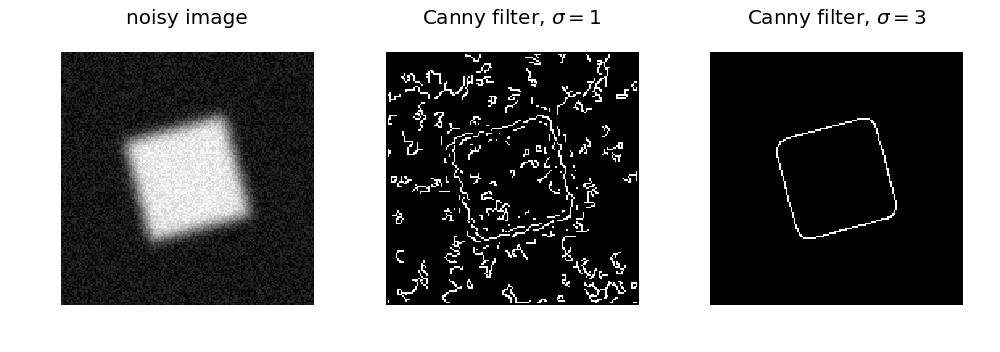

In [5]:

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

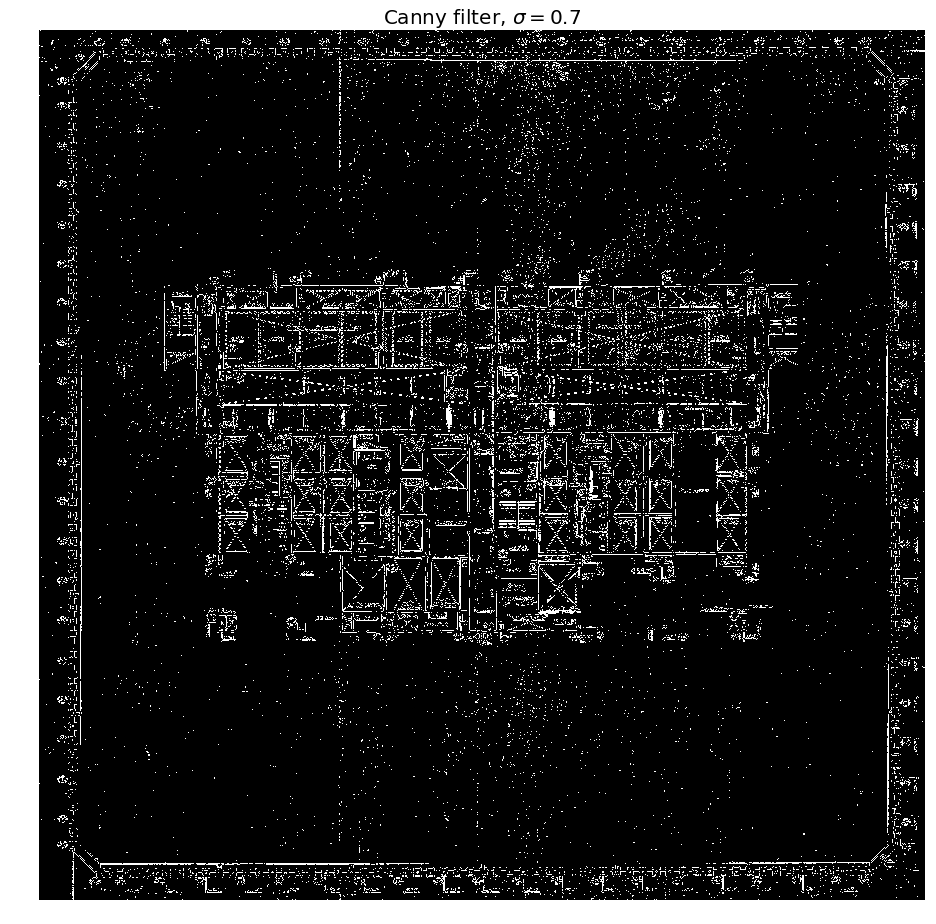

In [6]:
sigma = 0.7
edges6 = feature.canny(wtc_80_floor_image_gray, sigma=sigma)


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 16),
                                    sharex=True, sharey=True)

ax1.imshow(edges6, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Canny filter, $\sigma={}$'.format(sigma), fontsize=20)

fig.savefig('EdgeDetectionSigma_{}.png'.format(sigma), 
            dpi=350)

### Applying Skeletonize 

Implemented as [`skeletonize`](http://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html).

Seems not to be too helpful here, since it reduces area into lines. The edge detection however produces thin enough lines already.

In [7]:
# Set image.
image = edges6

# perform skeletonization
skeleton = skeletonize(image)

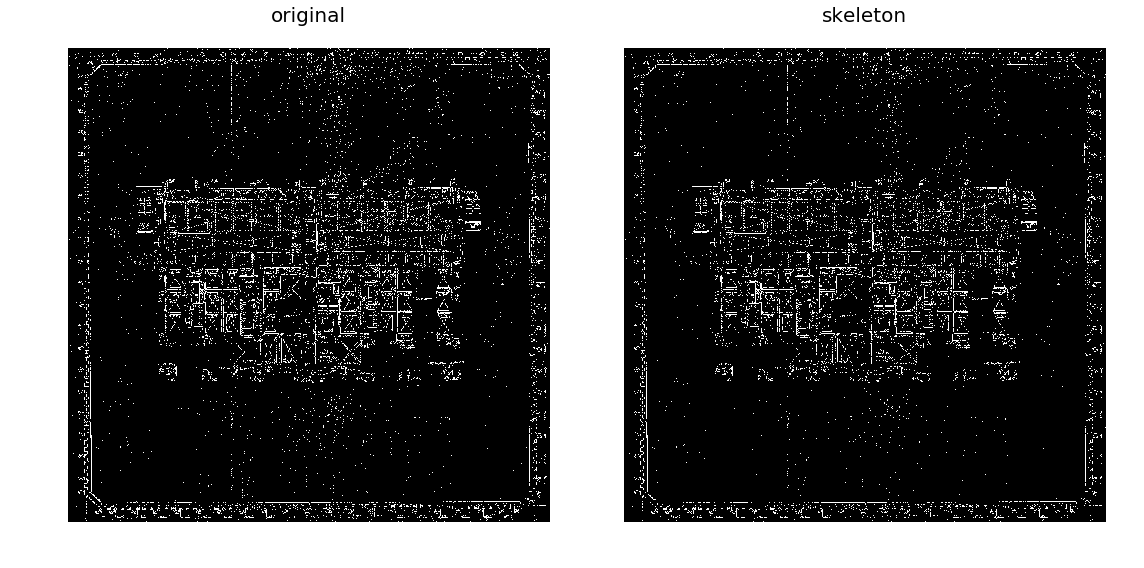

In [8]:
# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
# plt.show()

fig.savefig('EdgeDetectionSkeleton.png', 
            dpi=350)

## Edge Detection with Active Contour

[0, 2625, 2577, 0]

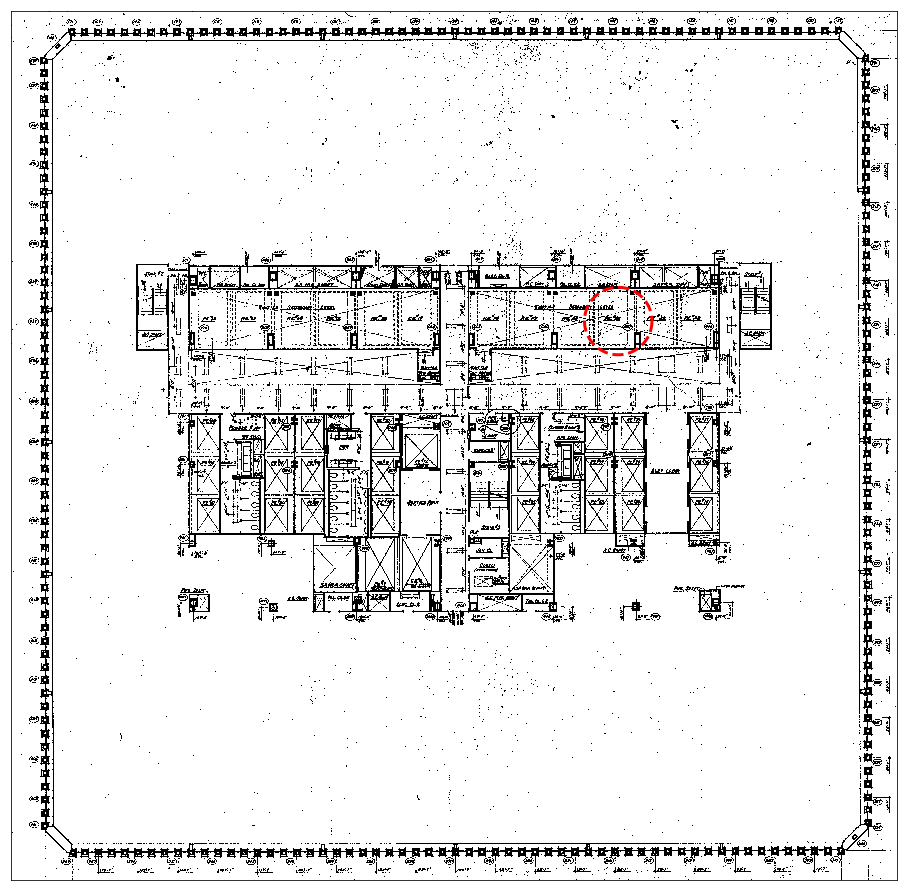

In [9]:
img_data = wtc_80_floor_image_gray

x_loc = 1800
y_loc = 920

# Set location for the active contour.
s = np.linspace(0, 2*np.pi, 400)
x = x_loc + (100)*np.cos(s)
y = y_loc + (100)*np.sin(s)
init = np.array([x, y]).T

# Check the location, defined above.
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(img_data, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
# ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_data.shape[1], img_data.shape[0], 0])

In [10]:
# Perform the active contour calculation.
snake = active_contour(gaussian(img_data, 3),
                       init, 
                       alpha=0.015,  # Snake length shape parameter. Higher values makes snake contract faster.
                       beta=5,  # Snake smoothness shape parameter. Higher values makes snake smoother.
                       gamma=0.001,  # Explicit time stepping parameter.
                       w_line=-3.0,  # Controls attraction to brightness. Use negative values to attract to dark regions.
                       w_edge=2.0)  # Controls attraction to edges. Use negative values to repel snake from edges.

[0, 2625, 2577, 0]

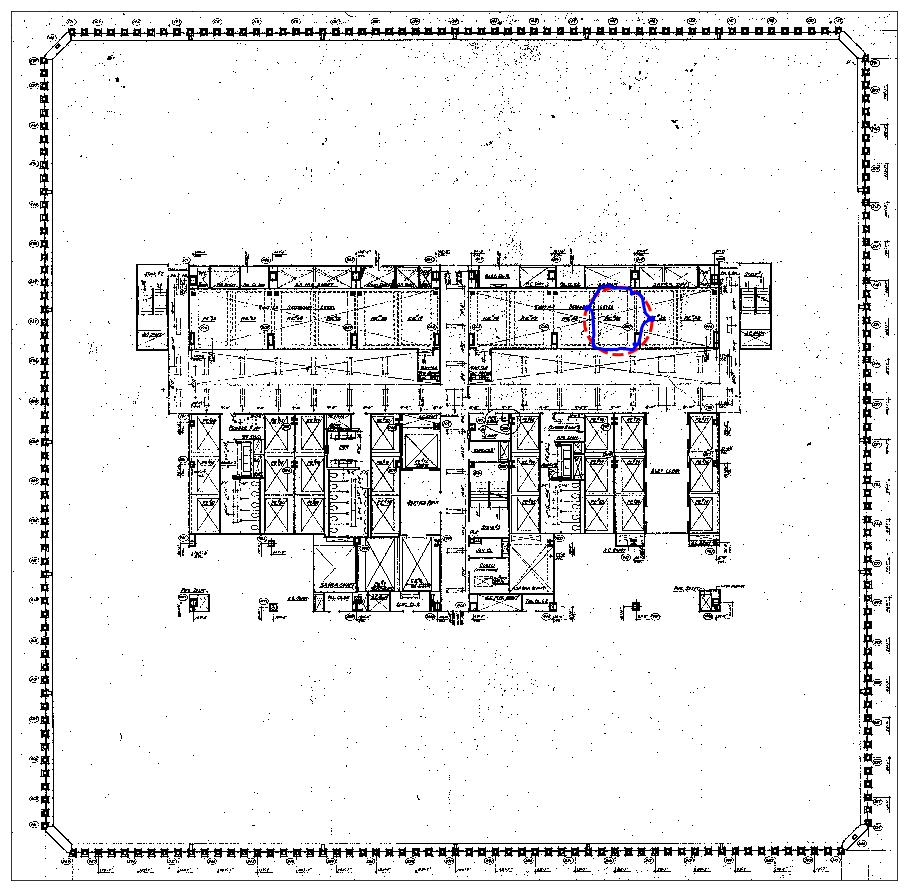

In [11]:
# Visualise the results.
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(img_data, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_data.shape[1], img_data.shape[0], 0])

## Morphological Active Contours without Edges (MorphACWE)

Implemented as [`morphological_chan_vese`](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_morphsnakes.html).

In [12]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
# image = img_as_float(data.camera())
image = wtc_80_floor_image_gray

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)



Text(0.5,1,'Morphological ACWE evolution')

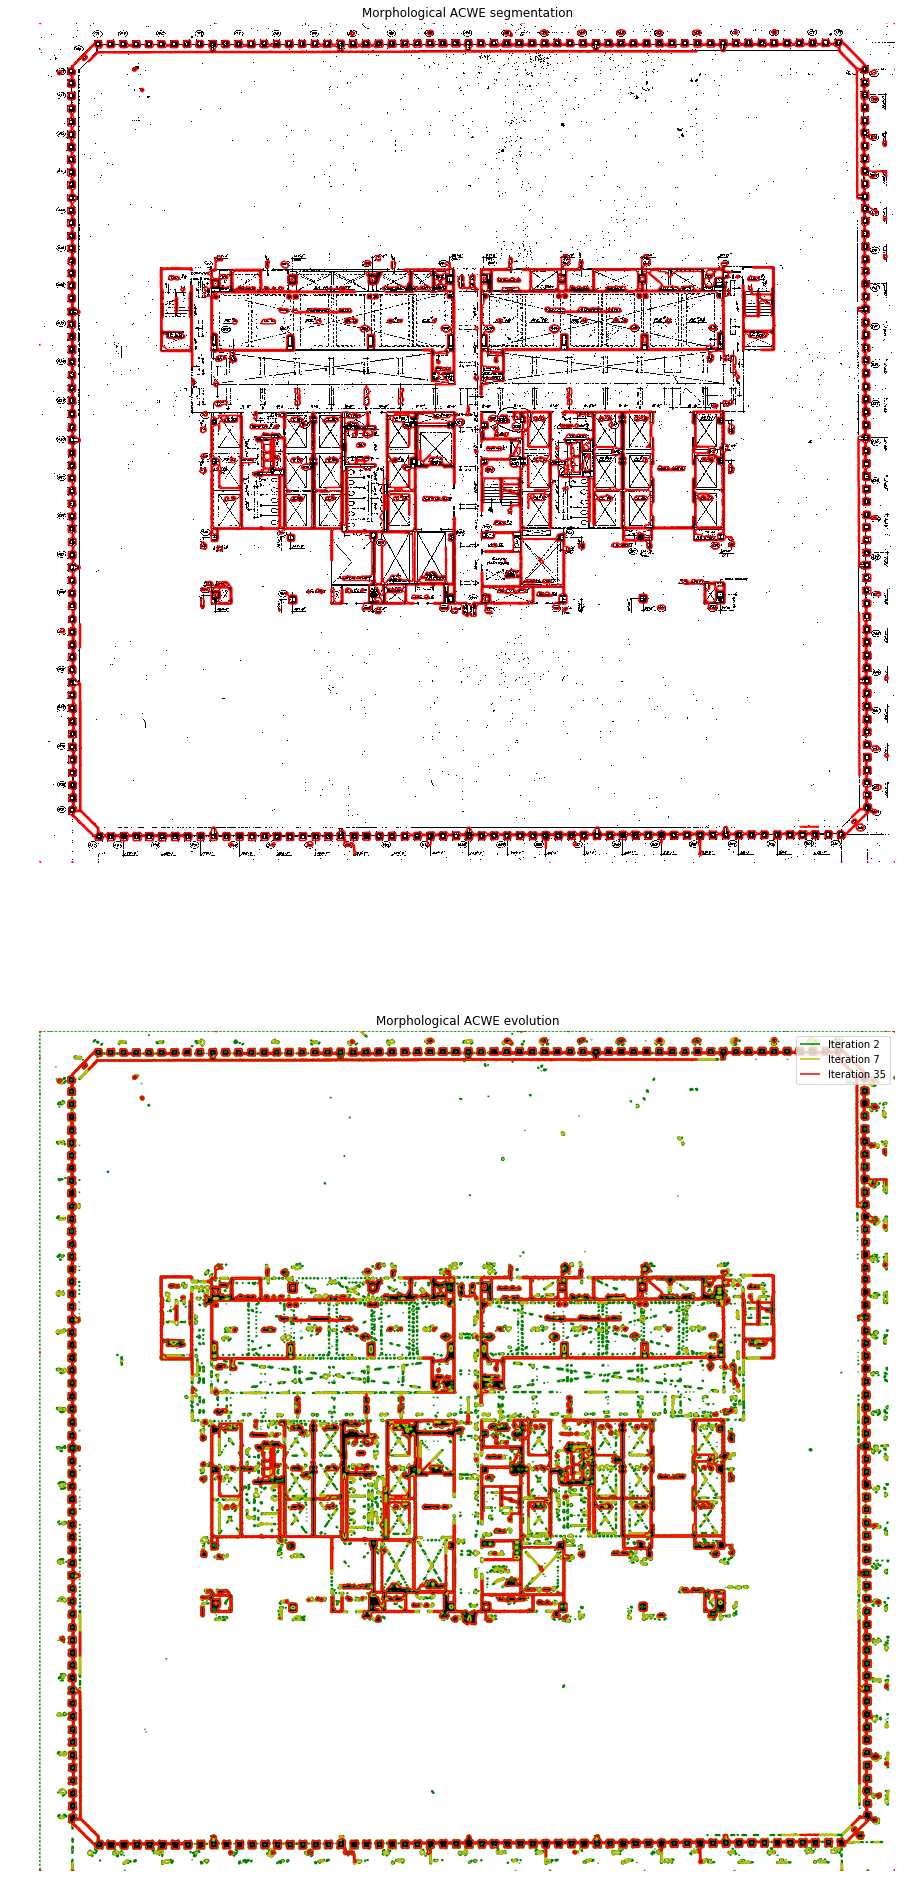

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 34))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)

## Morphological Geodesic Active Contours (MorphGAC)

Implemented as [`morphological_geodesic_active_contour`](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_morphsnakes.html).

In [14]:
# Morphological GAC
image = wtc_80_floor_image_gray
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.1,
                                           iter_callback=callback)



Text(0.5,1,'Morphological GAC evolution')

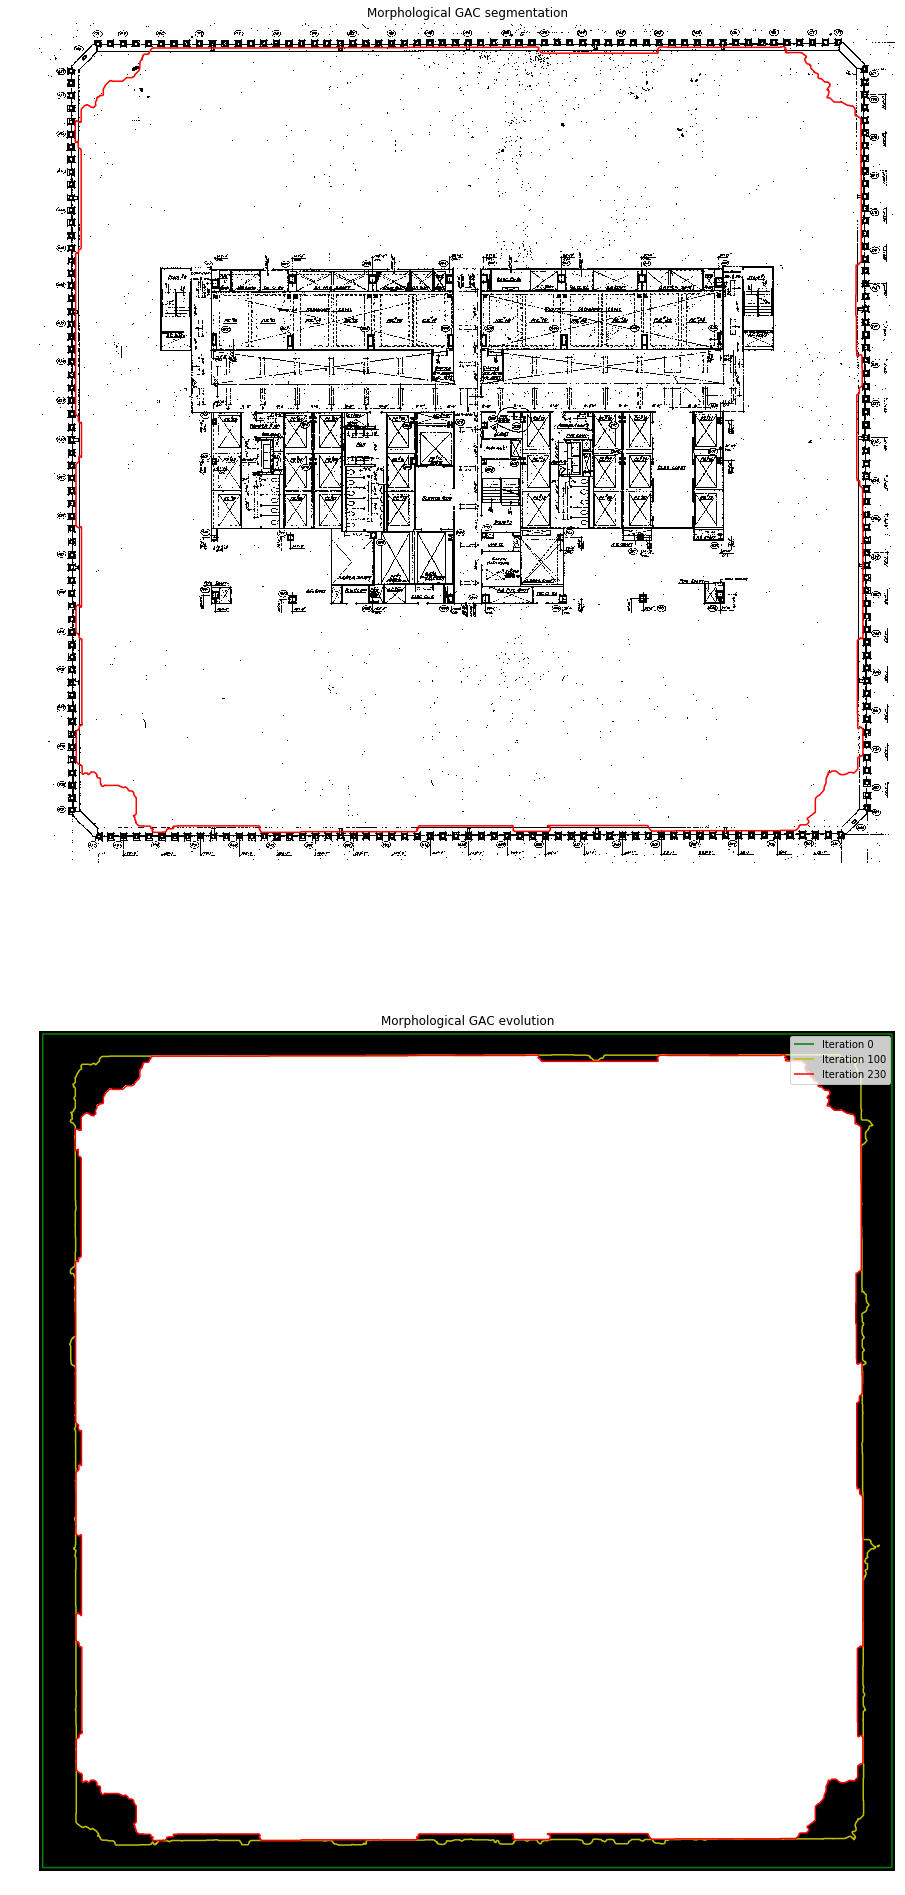

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(16, 34))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

## Contour finding

Implemented as [`find_contours`](http://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py).

In [17]:
r = wtc_80_floor_image_gray

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

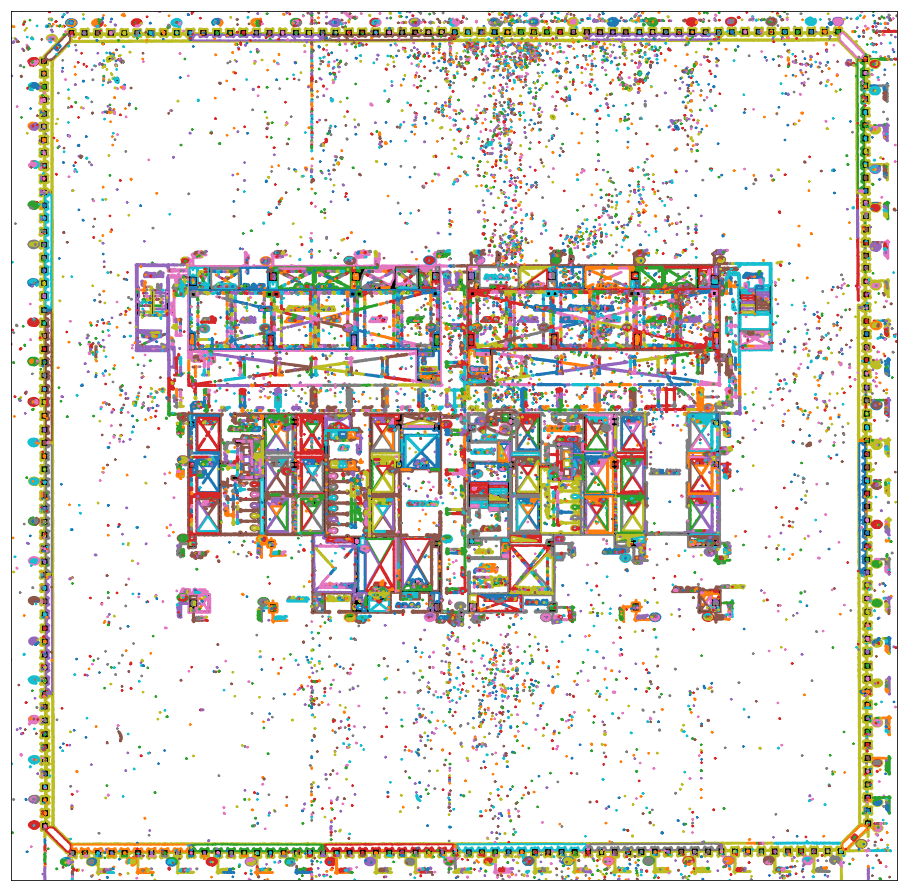

In [19]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [28]:
np.linspace(0.0, 1.0, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [33]:
ridge_brush_file = os.path.join('Pictures', 'RidgeBrushTest01.png')
ridge_brush_image = io.imread(ridge_brush_file)
ridge_brush_image_gray = rgb2gray(ridge_brush_image)


r = ridge_brush_image_gray

# Find contours at a constant value of 0.8
contours = []
for i in np.linspace(0.0, 1.0, 40):
    cont = measure.find_contours(r, i)
    contours.append(cont)

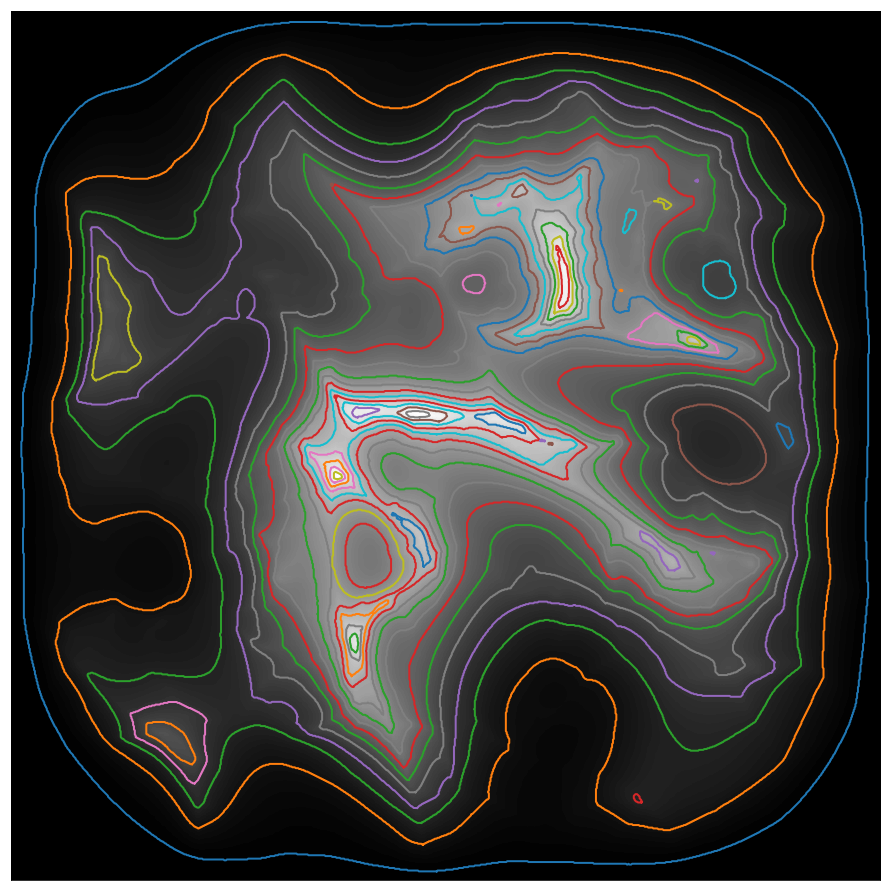

In [34]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for cnt in contours:
    for n, contour in enumerate(cnt):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()